<a href="https://colab.research.google.com/github/HamnahJ99/lightkurve-exoplanet-ml-project/blob/main/project-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 103.1 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=43b68aea3cf27ed69d9131c937976cadd158943c79e55db8466103c7470e269a
  Stored in directory: /root/.cache/pip/wheels/04/15/cd/2f622795b09e83471a3be5d2581cd9cf96a6ec7aa78e8deffe
  Created wheel for memoizatio

/usr/local/lib/python3.12/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


# 1. Smoothing Lightcurves
*   2 positive examples - stars with known exoplanets
*   2 negative examples - stars with no known exoplanets

Output: 4 graphs containing raw lightcurve and smoothed lightcurve



/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

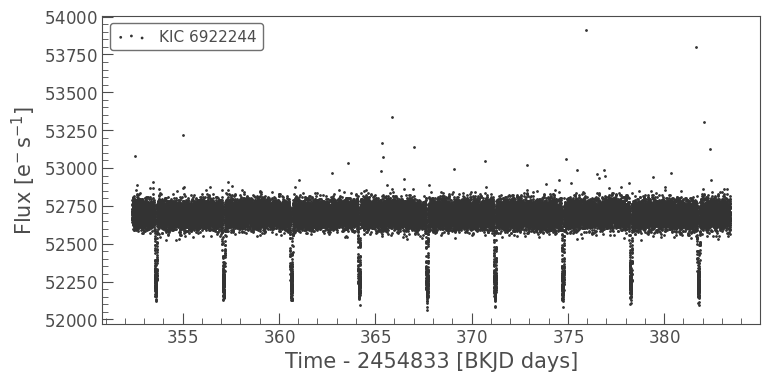

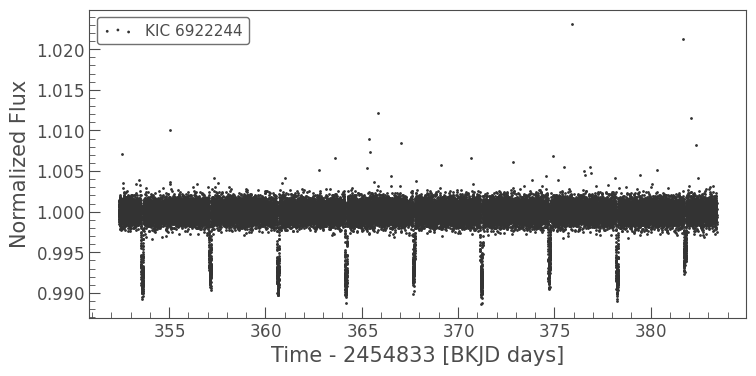

In [5]:
#Positive examples 1: 'KIC 6922244', quarter=4
#First step is removing NaN values
lc_2 = lk.search_lightcurve("KIC 6922244", quarter=4).download().remove_nans()
lc_2.scatter()
#Second step is to flatten the curve, though it is relatively flat
flat_lc_2 = lc_2.flatten(window_length=401)
flat_lc_2.scatter()
#using scatter graph for the first 2 grapsh instead of line graph as it is clearer to see the features

Best fit period:  3.520 d


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

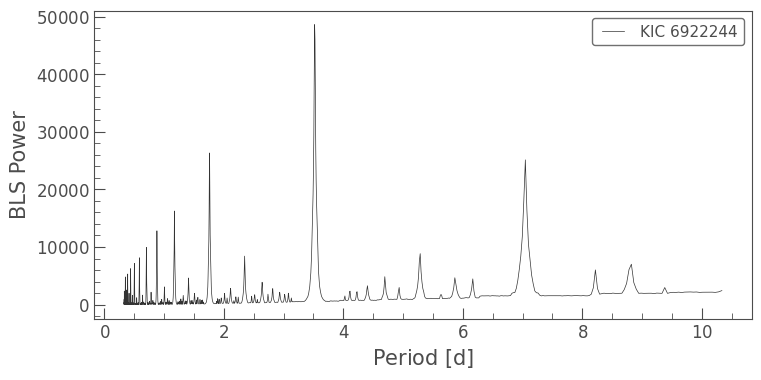

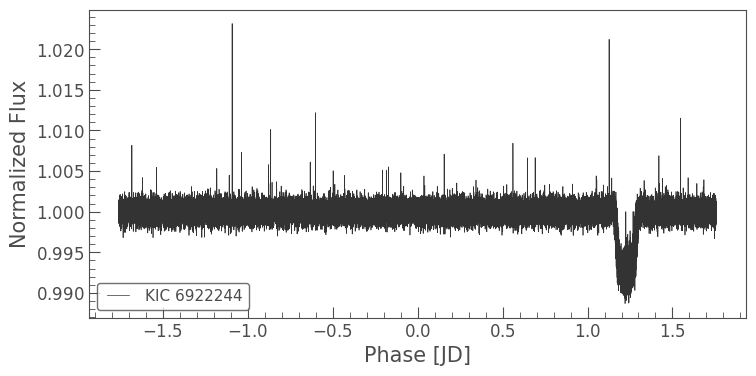

In [6]:
#Third step is to fold the graph (as the periods are relatively short) using a period calculated
#using the peak in the periodogram
periodogram = flat_lc_2.to_periodogram(method='bls')
periodogram.plot()
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {: .3f}' .format(best_fit_period))
folded_lc_2 = flat_lc_2.fold(period=best_fit_period)
folded_lc_2.plot()

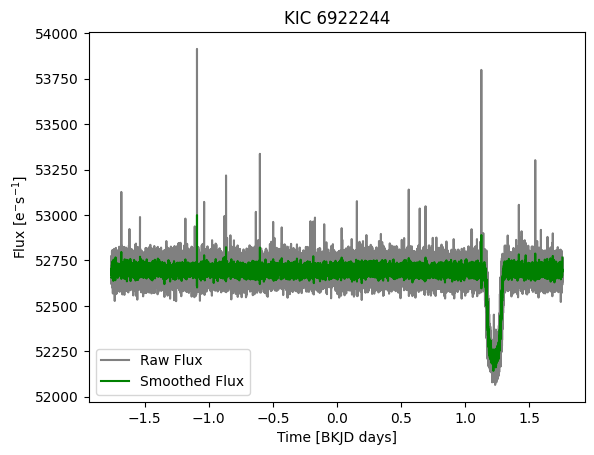

In [21]:
#Fourth step is to smooth the lightcurve using Savitzky-Golay
window_length = 13
poly_order = 3
time = folded_lc_2['time'].value
flux = folded_lc_2['pdcsap_flux']
y_smooth = savgol_filter(flux, window_length=window_length, polyorder=poly_order)

plt.plot(time, flux, color='grey', label='Raw Flux')  #Raw lightcurve
plt.plot(time, y_smooth, color='green', label='Smoothed Flux') #Smoothed lightcurve
plt.xlabel('Time [BKJD days]')
plt.ylabel('Flux [e$^{-}$s$^{-1}$]')
plt.title('KIC 6922244')
plt.legend()
plt.show()

In [25]:
#Building two functions that will smooth the 3 remaining lightcurves in the same way
#as the one just smoothed
#Need to be smoothed in the same way for the machine learning
#First function will smooth with folding for the lightcurves with relatively short periods
#Second function will smooth without folding for the lightcurves with relatively long periods
#Keeping parameters for savgol_filter the same: window_length=13, poly_order = 3

def smooth_lightcurve_fold(code, lc, flatten_wl, window_length, poly_order, colour):
  lc = lc.remove_nans().flatten(window_length=flatten_wl)
  periodogram = lc.to_periodogram(method='bls')
  best_fit_period = periodogram.period_at_max_power
  folded_lc = lc.fold(period=best_fit_period)
  print('Best fit period: {: .3f}' .format(best_fit_period))
  time = folded_lc['time'].value
  flux = folded_lc['pdcsap_flux']
  y_smooth = savgol_filter(flux, window_length=window_length, polyorder=poly_order)
  plt.plot(time, flux, color='grey', label='Raw Flux')
  plt.plot(time, y_smooth, color=colour, label='Smoothed Flux')
  plt.xlabel('Time [BKJD days]')
  plt.ylabel('Flux [e$^{-}$s$^{-1}$]')
  plt.title(code)
  plt.legend()
  plt.show()
  return plt.show()

def smooth_lightcurve(code, lc, flatten_wl, window_length, poly_order, colour):
  lc = lc.remove_nans().flatten(window_length=flatten_wl)
  periodogram = lc.to_periodogram(method='bls')
  best_fit_period = periodogram.period_at_max_power
  time = lc['time'].value
  flux = lc['pdcsap_flux']
  y_smooth = savgol_filter(flux, window_length=window_length, polyorder=poly_order)
  plt.plot(time, flux, color='grey', label='Raw Flux')
  plt.plot(time, y_smooth, color=colour, label='Smoothed Flux')
  plt.xlabel('Time [BKJD days]')
  plt.ylabel('Flux [e$^{-}$s$^{-1}$]')
  plt.title(code)
  plt.legend()
  plt.show()
  return plt.show()

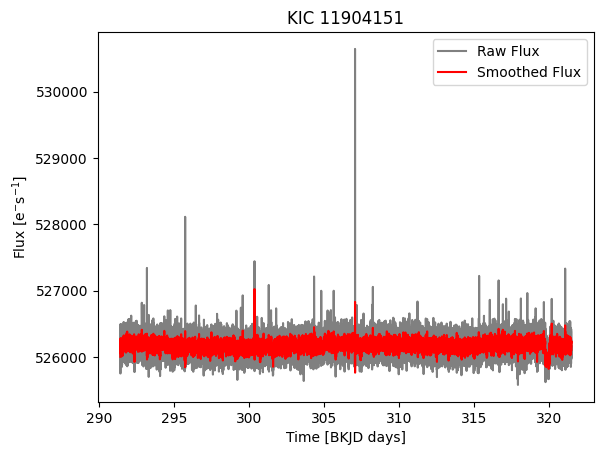

In [16]:
#Positive example 2: 'KIC 11904151', quarter=3
search_result = lk.search_lightcurve("Kepler-10")
lc_1 = search_result[2].download()
#lc_1.plot()

#not using folding as periods are relatively large
smooth_lightcurve('KIC 11904151', lc_1, 3000, 13, 3,'red')

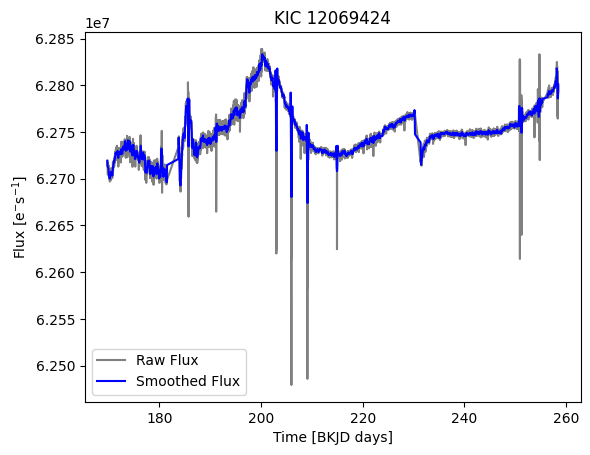

In [17]:
#Negative example 1: 'KIC 12069424', quarter=2
lc_3 = lk.search_lightcurve('KIC 12069424', quarter=2).download()
#lc_3.plot()

#Not using folding as periods are relatively large
smooth_lightcurve('KIC 12069424', lc_3, 3000, 13, 3,'blue')

Best fit period:  0.497 d


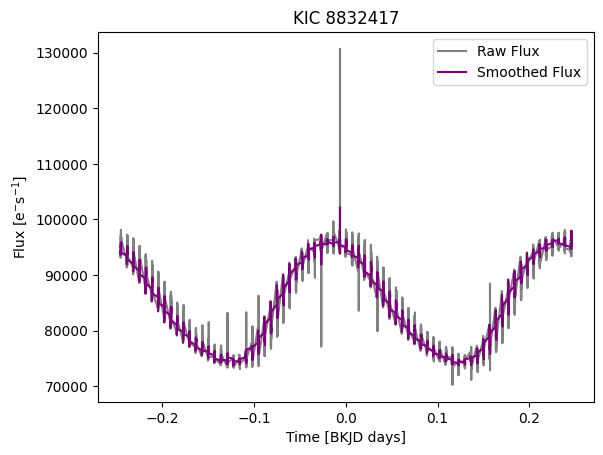

In [26]:
#Negative example 2: 'KIC 8832417', quarter=10
lc_4 = lk.search_lightcurve('KIC 8832417', quarter=10).download()
#lc_4.plot()

#Using folding as the periods are smaller
smooth_lightcurve_fold('KIC 8832417', lc_4, 3000, 13, 3,'purple')